In [44]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = './data/plantvillage/'
print(data_dir)

./data/plantvillage/


In [39]:
image_datasets = datasets.ImageFolder(root=data_dir)
class_names = image_datasets.classes
print(f'Number of Classes: {len(class_names)}\nData set class names: \n{class_names}')

Number of Classes: 38
Data set class names: 
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites 

In [28]:
train, val, test = torch.utils.data.random_split(image_datasets, [0.8, 0.1, 0.1])
print(f'No of train: {len(train)} | No of val: {len(val)} | No of test: {len(test)} | ')

No of train: 43445 | No of val: 5430 | No of test: 5430 | 


In [57]:
class PlantVillageDataset(Dataset):
	def __init__(self, datasets, transform=None):
		self.dataset = datasets
		self.transform = transform
		
	def __getitem__(self, index):
		return self.dataset[index]

	def __len__(self):
		return len(self.dataset)

0 is class 16
1 is class 33
2 is class 25
3 is class 8
4 is class 29
5 is class 12


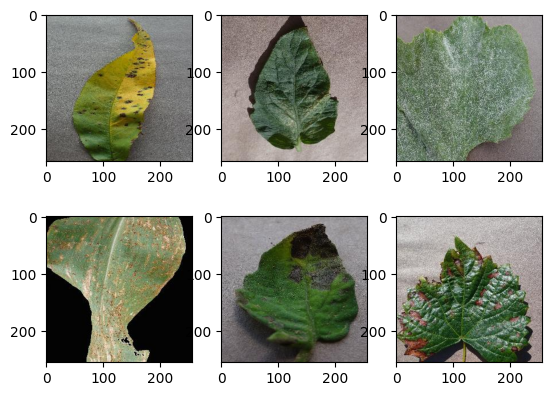

In [58]:
train_data = PlantVillageDataset(train)
val_data = PlantVillageDataset(val)
test_data = PlantVillageDataset(test)
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(train_data[i][0], cmap='grey')
    print(f'{i} is class {train_data[i][1]}')
plt.show()

In [60]:
train_data_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_data_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=25):
	start_time = time.time()
	best_model_weights = copy.deepcopy(model.state_dict())
	best_accuracy = 0.0

	for epoch in range(n_epochs):
		print(f'Epoch {epoch+1}/{n_epochs}')
		print('-' * 50)

		for phase in ['train', 'val']:
			if phase == 'train':
				model.train()
			else:
				model.eval()

			running_loss = 0.0
			running_corrects = 0

			for inputs, labels in dataloaders[phase]:
				inputs = inputs.to(device)
				labels = labels.to(device)

				# Foward
				with torch.set_grad_enabled(phase == 'train'):
					outputs = model(inputs)
					_, pred = torch.max(outputs, 1)
					loss = criterion(outputs, labels)

					# Bacward > Optimize
					if phase == 'train':
						optimizer.zero_grad()
						loss.backward()
						optimizer.step()
				# Statistic
				running_loss += loss.item() * inputs.size(0)
				running_corrects += torch.sum(pred == labels.data)

			if phase == 'train':
				scheduler.step()

			epoch_loss = running_loss / dataset_size[phase]
			epoch_accuracy = running_corrects.double() / dataset_size[phase]
			print(f'Phase: {phase}\t| Loss: {epoch_loss:.4f}\t| Accuracy: {epoch_accuracy:.4f}')

			# Deep copy model
			if phase == 'val' and epoch_accuracy > best_accuracy:
				best_accuracy = epoch_accuracy
				best_model_weights = copy.deepcopy(model.state_dict())
		print('-' * 50)
		print()

	end_time = time.time() - start_time
	print(f'\n{"="*50}\n')
	print(f' Training complete in {end_time//60:.0f}m {end_time%60:.0f}s')
	print(f' Best Accuracy: {best_accuracy:.4f}')
	print(f'\n{"="*50}\n')
	# Load best model weights
	model.load_state_dict(best_model_weights)
	return model
